Data: Imported directly from the Chicago Data Portal

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from numpy.linalg import eig
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

<h3> STEP 1</h3>
Let's read in up to 100,000 rows of COVID data for Chicago from the Chicago Data Portal.
We create a list called chipzip of the Chicago zip codes.

In [2]:
import pandas as pd
import numpy as np
rawCOVID = pd.read_json('https://data.cityofchicago.org/resource/yhhz-zm2v.json?$limit=100000') #Import data directly from data portal
rawCOVID.head(2)

,:@computed_region_43wa_7qmu,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,case_rate_cumulative,case_rate_weekly,cases_cumulative,cases_weekly,death_rate_cumulative,...,row_id,test_rate_cumulative,test_rate_weekly,tests_cumulative,tests_weekly,week_end,week_number,week_start,zip_code,zip_code_location
0,36.0,14311.0,367.0,34.0,38.0,NaN,NaN,NaN,NaN,0.0,...,60603-2020-10,0.0,0.0,0,0.0,2020-03-07T00:00:00.000,10,2020-03-01T00:00:00.000,60603,"{'type': 'Point', 'coordinates': [-87.625473, ..."
1,36.0,14311.0,367.0,34.0,38.0,NaN,NaN,NaN,NaN,0.0,...,60603-2020-11,0.0,0.0,0,0.0,2020-03-14T00:00:00.000,11,2020-03-08T00:00:00.000,60603,"{'type': 'Point', 'coordinates': [-87.625473, ..."


We'll list the 26 column names

In [3]:
list(rawCOVID.columns)

[':@computed_region_43wa_7qmu',
 ':@computed_region_6mkv_f3dw',
 ':@computed_region_bdys_3d7i',
 ':@computed_region_rpca_8um6',
 ':@computed_region_vrxf_vc4k',
 'case_rate_cumulative',
 'case_rate_weekly',
 'cases_cumulative',
 'cases_weekly',
 'death_rate_cumulative',
 'death_rate_weekly',
 'deaths_cumulative',
 'deaths_weekly',
 'percent_tested_positive_cumulative',
 'percent_tested_positive_weekly',
 'population',
 'row_id',
 'test_rate_cumulative',
 'test_rate_weekly',
 'tests_cumulative',
 'tests_weekly',
 'week_end',
 'week_number',
 'week_start',
 'zip_code',
 'zip_code_location']

Let's list the zipcodes

In [4]:
rawCOVID["zip_code"].value_counts()


60618      144
60642      144
60614      144
60661      144
60613      144
60632      144
60639      144
60617      144
60602      144
60638      144
60603      144
60657      144
60637      144
60633      144
60636      144
60620      144
60608      144
60628      144
60611      144
60640      144
60623      144
60655      144
60660      144
60624      144
60609      144
60626      144
60651      144
60827      144
60619      144
60659      144
60610      144
60604      144
60666      144
60645      144
60615      144
60644      144
60707      144
60652      144
60646      144
60629      144
Unknown    144
60622      144
60641      144
60647      144
60643      144
60612      144
60606      144
60653      144
60631      144
60605      144
60621      144
60656      144
60607      144
60625      144
60630      144
60601      144
60634      144
60616      144
60649      144
60654      144
Name: zip_code, dtype: int64

In [5]:
zips=rawCOVID["zip_code"].value_counts()
ziplist=zips.sort_index()
ziplist.index

Index(['60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
       '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
       '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
       '60625', '60626', '60628', '60629', '60630', '60631', '60632', '60633',
       '60634', '60636', '60637', '60638', '60639', '60640', '60641', '60642',
       '60643', '60644', '60645', '60646', '60647', '60649', '60651', '60652',
       '60653', '60654', '60655', '60656', '60657', '60659', '60660', '60661',
       '60666', '60707', '60827', 'Unknown'],
      dtype='object')

Q1. How many zipcodes are there in Chicago?

In [6]:
chizip=ziplist.index.drop('Unknown')
len(chizip)

59

In [7]:
chizip[0]

'60601'

<h3> STEP TWO </h3>
Let's streamline the data to just a few columns, drop rows with missing data,  simplify the column names, and then display the first 2 rows. We'll also flter the data for zip 60623.

In [8]:
COVID=rawCOVID[['deaths_cumulative', "population",  'tests_cumulative','zip_code']]
COVID.columns=["deaths","population","tests","zip"] #simplify the column names
COVID=COVID.dropna()
COVID.head(2)

,deaths,population,tests,zip
0,0,1174,0,60603
1,0,1174,0,60603


In [9]:
temp=COVID[COVID["zip"]=='60623']
temp.head(2)

,deaths,population,tests,zip
760,154,85979,16951,60623
768,229,85979,64444,60623


Q2. How many deaths occurred in 60623 for the consective weeks shown?

<h3>STEP THREE</h3>
Let's create a dataframe called data which contains for each zip code: (i) the population; (ii) the test rate (number of tests per person); and (iii) the death rate (number of deaths per 100,000 people).

In [10]:
data=pd.DataFrame()
for i in np.arange(0,59,1):
    z=chizip[i]
    temp = COVID[COVID["zip"]==z]
    p=temp["population"].max()
    t=temp["tests"].max()
    d=temp["deaths"].max()
    data.loc[i,"zip"]=z
    data.loc[i,"test rate"]=t/p  #test rate = number of tests per person
    data.loc[i,"death rate"]=d/p #death rate = number of deaths per person
data=data[data["zip"]!='60666'] #removes a zip with missing info
data=data.reset_index(drop=True) #renumbers the index
data.head()

C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  if __name__ == '__main__':
C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


,zip,test rate,death rate
0,60601,6.913867,0.000886
1,60602,9.665595,0.002412
2,60603,9.901193,0.000000
3,60604,19.681586,0.000000
4,60605,4.760166,0.000545


Q3. How is it possible for the death rate to be more than 100?  for the death rate to be equal to 0?

<h3> STEP THREE</h3>
Let's make a graph which shows the test rate and death rate by zip code. 

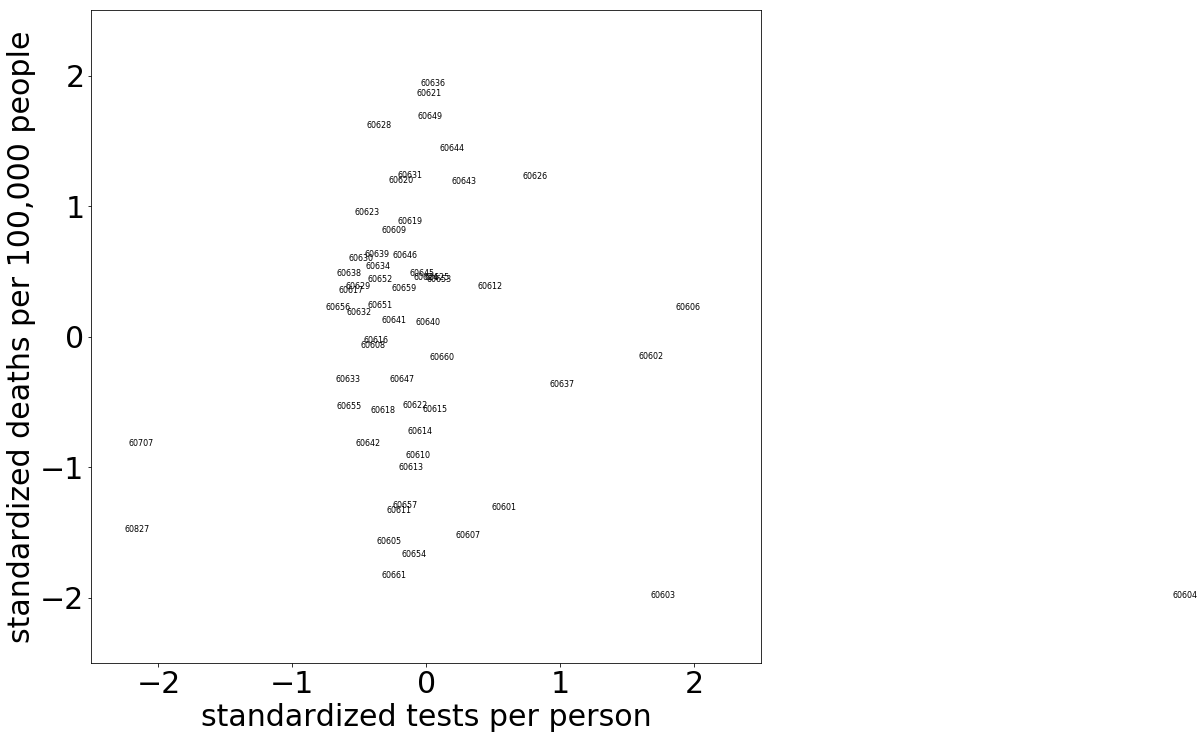

In [11]:
fig=plt.figure(figsize=(12,12))
plt.ylim(-2.5,2.5)
plt.xlim(-2.5,2.5)
xm=np.mean(data["test rate"])
xs=np.std(data["test rate"])
ym=np.mean(data["death rate"])
ys=np.std(data["death rate"])
#JOL = plt.imread("JOL.jpg")
#im = plt.imshow(JOL)
#plt.scatter(data["test rate"],data["death rate"],color='darkorange',s=200,alpha=.95)  #put markers 
for i in np.arange(0,58):
        z=data.loc[i,"zip"]
        plt.text((data.loc[i,"test rate"]-xm)/xs,(data.loc[i,"death rate"]-ym)/ys,z,size=8,color='black',ha='center',va='center')
        data.loc[i,"std test rate"]=(data.loc[i,"test rate"]-xm)/xs
        data.loc[i,"std death rate"]=(data.loc[i,"death rate"]-ym)/ys
plt.xlabel("standardized tests per person",size=30)
plt.ylabel("standardized deaths per 100,000 people",size=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig("chistandardcovid.png")

In [12]:
data.head()

,zip,test rate,death rate,std test rate,std death rate
0,60601,6.913867,0.000886,0.580469,-1.311419
1,60602,9.665595,0.002412,1.676577,-0.149852
2,60603,9.901193,0.000000,1.770423,-1.985848
3,60604,19.681586,0.000000,5.666289,-1.985848
4,60605,4.760166,0.000545,-0.277424,-1.570866


In [13]:
print("variance test rate",np.std(data["std test rate"])**2)
print("variance death rate",np.std(data["std death rate"])**2)

variance test rate 1.0
variance death rate 0.9999999999999991


In [14]:
data1=data[data["zip"]!='60707']
data1=data1[data1["zip"]!='60827']
data1=data1[data1["zip"]!='60606']
data1=data1[data1["zip"]!='60602']
data1=data1[data1["zip"]!='60603']
data1=data1[data1["zip"]!='60604']
print("variance test rate",np.std(data1["std test rate"])**2)
print("variance death rate",np.std(data1["std death rate"])**2)

variance test rate 0.11583206544615858
variance death rate 0.8931531613437289


In [15]:
data1.head()

,zip,test rate,death rate,std test rate,std death rate
0,60601,6.913867,0.000886,0.580469,-1.311419
4,60605,4.760166,0.000545,-0.277424,-1.570866
6,60607,6.242878,0.000608,0.313191,-1.522738
7,60608,4.460362,0.002525,-0.396846,-0.063429
8,60609,4.846996,0.003675,-0.242836,0.812098


In [16]:
data1=data1.reset_index(drop=True)
data1.head()

,zip,test rate,death rate,std test rate,std death rate
0,60601,6.913867,0.000886,0.580469,-1.311419
1,60605,4.760166,0.000545,-0.277424,-1.570866
2,60607,6.242878,0.000608,0.313191,-1.522738
3,60608,4.460362,0.002525,-0.396846,-0.063429
4,60609,4.846996,0.003675,-0.242836,0.812098


In [17]:
def cplot(x,y):
    m=np.array([x,y]).transpose()
    mt=np.array([x,y])
    A=np.dot(mt,m)/len(x)
    pca = PCA(n_components=1)
    PC = pca.fit_transform(m)
    pca = pd.DataFrame(data = PC, columns = ['Principal Component'])
    print("Data Matrix X:\n",m)
    print("Covariance Matrix A:\n",A)
    print("Eigenvalues and Eigenvectors of A:\n",eig(A))
    print("Principal Eigenvector= ("+str(pca.loc[0,"Principal Component"])+","+str(pca.loc[1,"Principal Component"])+")")
    print("Variance along x-axis",np.var(x))
    print("Variance along y-axis",np.var(y))
    s=0
    for i in np.arange(0,len(x),1):
        s=s+(x[i]*pca.loc[0,"Principal Component"]+y[i]*pca.loc[1,"Principal Component"])**2
    print("Variance along principal component",s/len(x))
    print("Scatterplot:")
    fig=plt.figure()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x,y,color='k',s=20)
    a=pca.loc[0,"Principal Component"]
    b=pca.loc[1,"Principal Component"]
    for i in np.arange(0,100,1):
        x1=x.min()+i*(x.max()-x.min())/100
        plt.text(x1, b*x1/a,'.')
    plt.xlabel("x",size=20)
    plt.ylabel("y",size=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig("cov.png") 

Data Matrix X:
 [[ 5.80469249e-01 -1.31141910e+00]
 [-2.77423769e-01 -1.57086556e+00]
 [ 3.13191268e-01 -1.52273825e+00]
 [-3.96845710e-01 -6.34286265e-02]
 [-2.42836412e-01  8.12098062e-01]
 [-5.87110812e-02 -9.12705552e-01]
 [-2.03694383e-01 -1.32843908e+00]
 [ 4.80178149e-01  3.88372876e-01]
 [-1.11074404e-01 -9.98355537e-01]
 [-4.77335699e-02 -7.26010466e-01]
 [ 6.39462009e-02 -5.57090614e-01]
 [-3.75878566e-01 -2.88551591e-02]
 [-5.60600042e-01  3.57147969e-01]
 [-3.25799643e-01 -5.66351092e-01]
 [-1.24276815e-01  8.85063925e-01]
 [-1.86867565e-01  1.20050549e+00]
 [ 2.20780930e-02  1.86770644e+00]
 [-8.54919615e-02 -5.29330181e-01]
 [-4.44094568e-01  9.53942589e-01]
 [ 1.07230671e-03  4.56594250e-01]
 [ 7.88878458e-02  4.54453703e-01]
 [ 8.09372369e-01  1.22908207e+00]
 [-3.50717749e-01  1.61973666e+00]
 [-5.07476604e-01  3.89680012e-01]
 [-4.87961740e-01  6.03064296e-01]
 [-1.18245649e-01  1.23694171e+00]
 [-5.02923179e-01  1.88437624e-01]
 [-5.82978187e-01 -3.29633835e-01]
 [-3

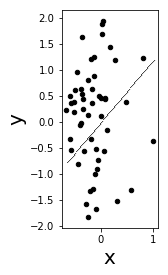

In [18]:
x=data1['std test rate']
y=data1['std death rate']
cplot(x,y)